# 1. Forward Stepwise Regression using R² for feature selection for M+H Adduct, positive mode

Number of rows after cleaning columns: 38
Number of columns after removing missing columns: 644


Performing Forward Stepwise Regression (R²):   0%| | 1/644 [00:00<05:55,  1.81it

Added Feature: GATS1s, R²: 0.5665


Performing Forward Stepwise Regression (R²):   0%| | 2/644 [00:01<06:07,  1.75it

Added Feature: GATS3m, R²: 0.7576


Performing Forward Stepwise Regression (R²):   0%| | 3/644 [00:01<06:21,  1.68it

Added Feature: nN, R²: 0.7771


Performing Forward Stepwise Regression (R²):   1%| | 4/644 [00:02<06:45,  1.58it

Added Feature: VR2_D, R²: 0.7921


Performing Forward Stepwise Regression (R²):   1%| | 5/644 [00:03<07:07,  1.49it

Added Feature: R_TpiPCTPC, R²: 0.8101


Performing Forward Stepwise Regression (R²):   1%| | 6/644 [00:03<07:31,  1.41it

Added Feature: MATS4s, R²: 0.8463


Performing Forward Stepwise Regression (R²):   1%| | 7/644 [00:04<07:56,  1.34it

Added Feature: MATS1s, R²: 0.8895


Performing Forward Stepwise Regression (R²):   1%| | 8/644 [00:05<08:21,  1.27it

Added Feature: MATS3c, R²: 0.9077


Performing Forward Stepwise Regression (R²):   1%| | 9/644 [00:06<08:50,  1.20it

Added Feature: GATS2s, R²: 0.9275


Performing Forward Stepwise Regression (R²):   2%| | 10/644 [00:07<09:15,  1.14i

Added Feature: VR2_Dt, R²: 0.9413


Performing Forward Stepwise Regression (R²):   2%| | 10/644 [00:08<09:04,  1.16i


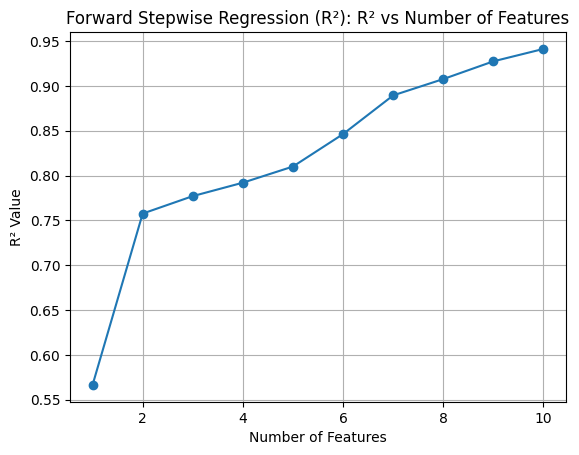

       Feature      Weight
0    Intercept    7.228852
1       GATS1s  -19.401627
2       GATS3m   12.591580
3           nN    1.043157
4        VR2_D    0.158381
5   R_TpiPCTPC  -12.888380
6       MATS4s  113.439417
7       MATS1s    8.705634
8       MATS3c   -8.918629
9       GATS2s   22.492773
10      VR2_Dt   -0.347562


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
from tqdm import tqdm  # Progress bar
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")

# Forward Stepwise Regression using R² for feature selection
def forward_selection_with_r2_threshold(X, y, r2_threshold=0.001):
    initial_features = []
    r2_values = []
    current_r2 = 0
    remaining_features = [col for col in X.columns if col not in initial_features]
    
    # Use tqdm to track progress
    with tqdm(total=len(remaining_features), desc="Performing Forward Stepwise Regression (R²)") as pbar:
        while True:
            remaining_features = [col for col in X.columns if col not in initial_features]
            new_r2 = pd.Series(index=remaining_features)
            for new_column in remaining_features:
                model = sm.OLS(y, sm.add_constant(X[initial_features + [new_column]])).fit()
                new_r2[new_column] = model.rsquared
            best_feature = new_r2.idxmax()
            best_r2 = new_r2.max()
            
            # Check if the improvement in R² is above the threshold
            if (best_r2 - current_r2) > r2_threshold:
                initial_features.append(best_feature)
                current_r2 = best_r2
                r2_values.append(current_r2)
                pbar.update(1)  # Update progress bar
                print(f"Added Feature: {best_feature}, R²: {current_r2:.4f}")
            else:
                break
    return initial_features, r2_values

# Load your dataset (replace 'your_file_path.xlsx' with the actual file path)
file_path = 'IE-training-file-standard-final.xlsx'
mh_sheet = pd.read_excel(file_path, sheet_name='M+H')

# Define the target variable (logRIE) and exclude unnecessary columns
exclude_columns = ['index', 'Molecule List', 'Molecule', 'SMILES', 'Adduct', 
                   'isotopic correction factor', 'Slope', 'RIE(LPE)', 'logRIE(LPE)']

# Select relevant features and target
X = mh_sheet.drop(columns=exclude_columns)  # Drop logRIE(LPE) from features
y = mh_sheet['logRIE(LPE)']  # Set logRIE(LPE) as the target

# Remove columns that have missing values (while keeping all rows)
X = X.dropna(axis=1)

# Ensure the number of rows in the dataset after cleaning columns
print(f"Number of rows after cleaning columns: {len(y)}")
print(f"Number of columns after removing missing columns: {X.shape[1]}")

# Perform Forward Stepwise Regression using R² with a threshold for improvement
selected_features_forward, r2_values_forward = forward_selection_with_r2_threshold(X, y, r2_threshold=0.01)

# Plot R² values against number of features
plt.plot(range(1, len(r2_values_forward) + 1), r2_values_forward, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('R² Value')
plt.title('Forward Stepwise Regression (R²): R² vs Number of Features')
plt.grid(True)
plt.show()

# Build the final model using the selected features
final_model = sm.OLS(y, sm.add_constant(X[selected_features_forward])).fit()

# Predict logRIE(LPE) values using the final model
y_pred = final_model.predict(sm.add_constant(X[selected_features_forward]))

# Extract the feature names and their corresponding coefficients (weights)
feature_weights = pd.DataFrame({
    'Feature': ['Intercept'] + selected_features_forward,
    'Weight': final_model.params.values
})

# Define the output file path (you can specify your preferred file path)
output_file_path = 'selected_features_and_weights-M+H.xlsx'

# Export to Excel file
feature_weights.to_excel(output_file_path, index=False)

# Optionally, display the DataFrame with the features and their weights
print(feature_weights)


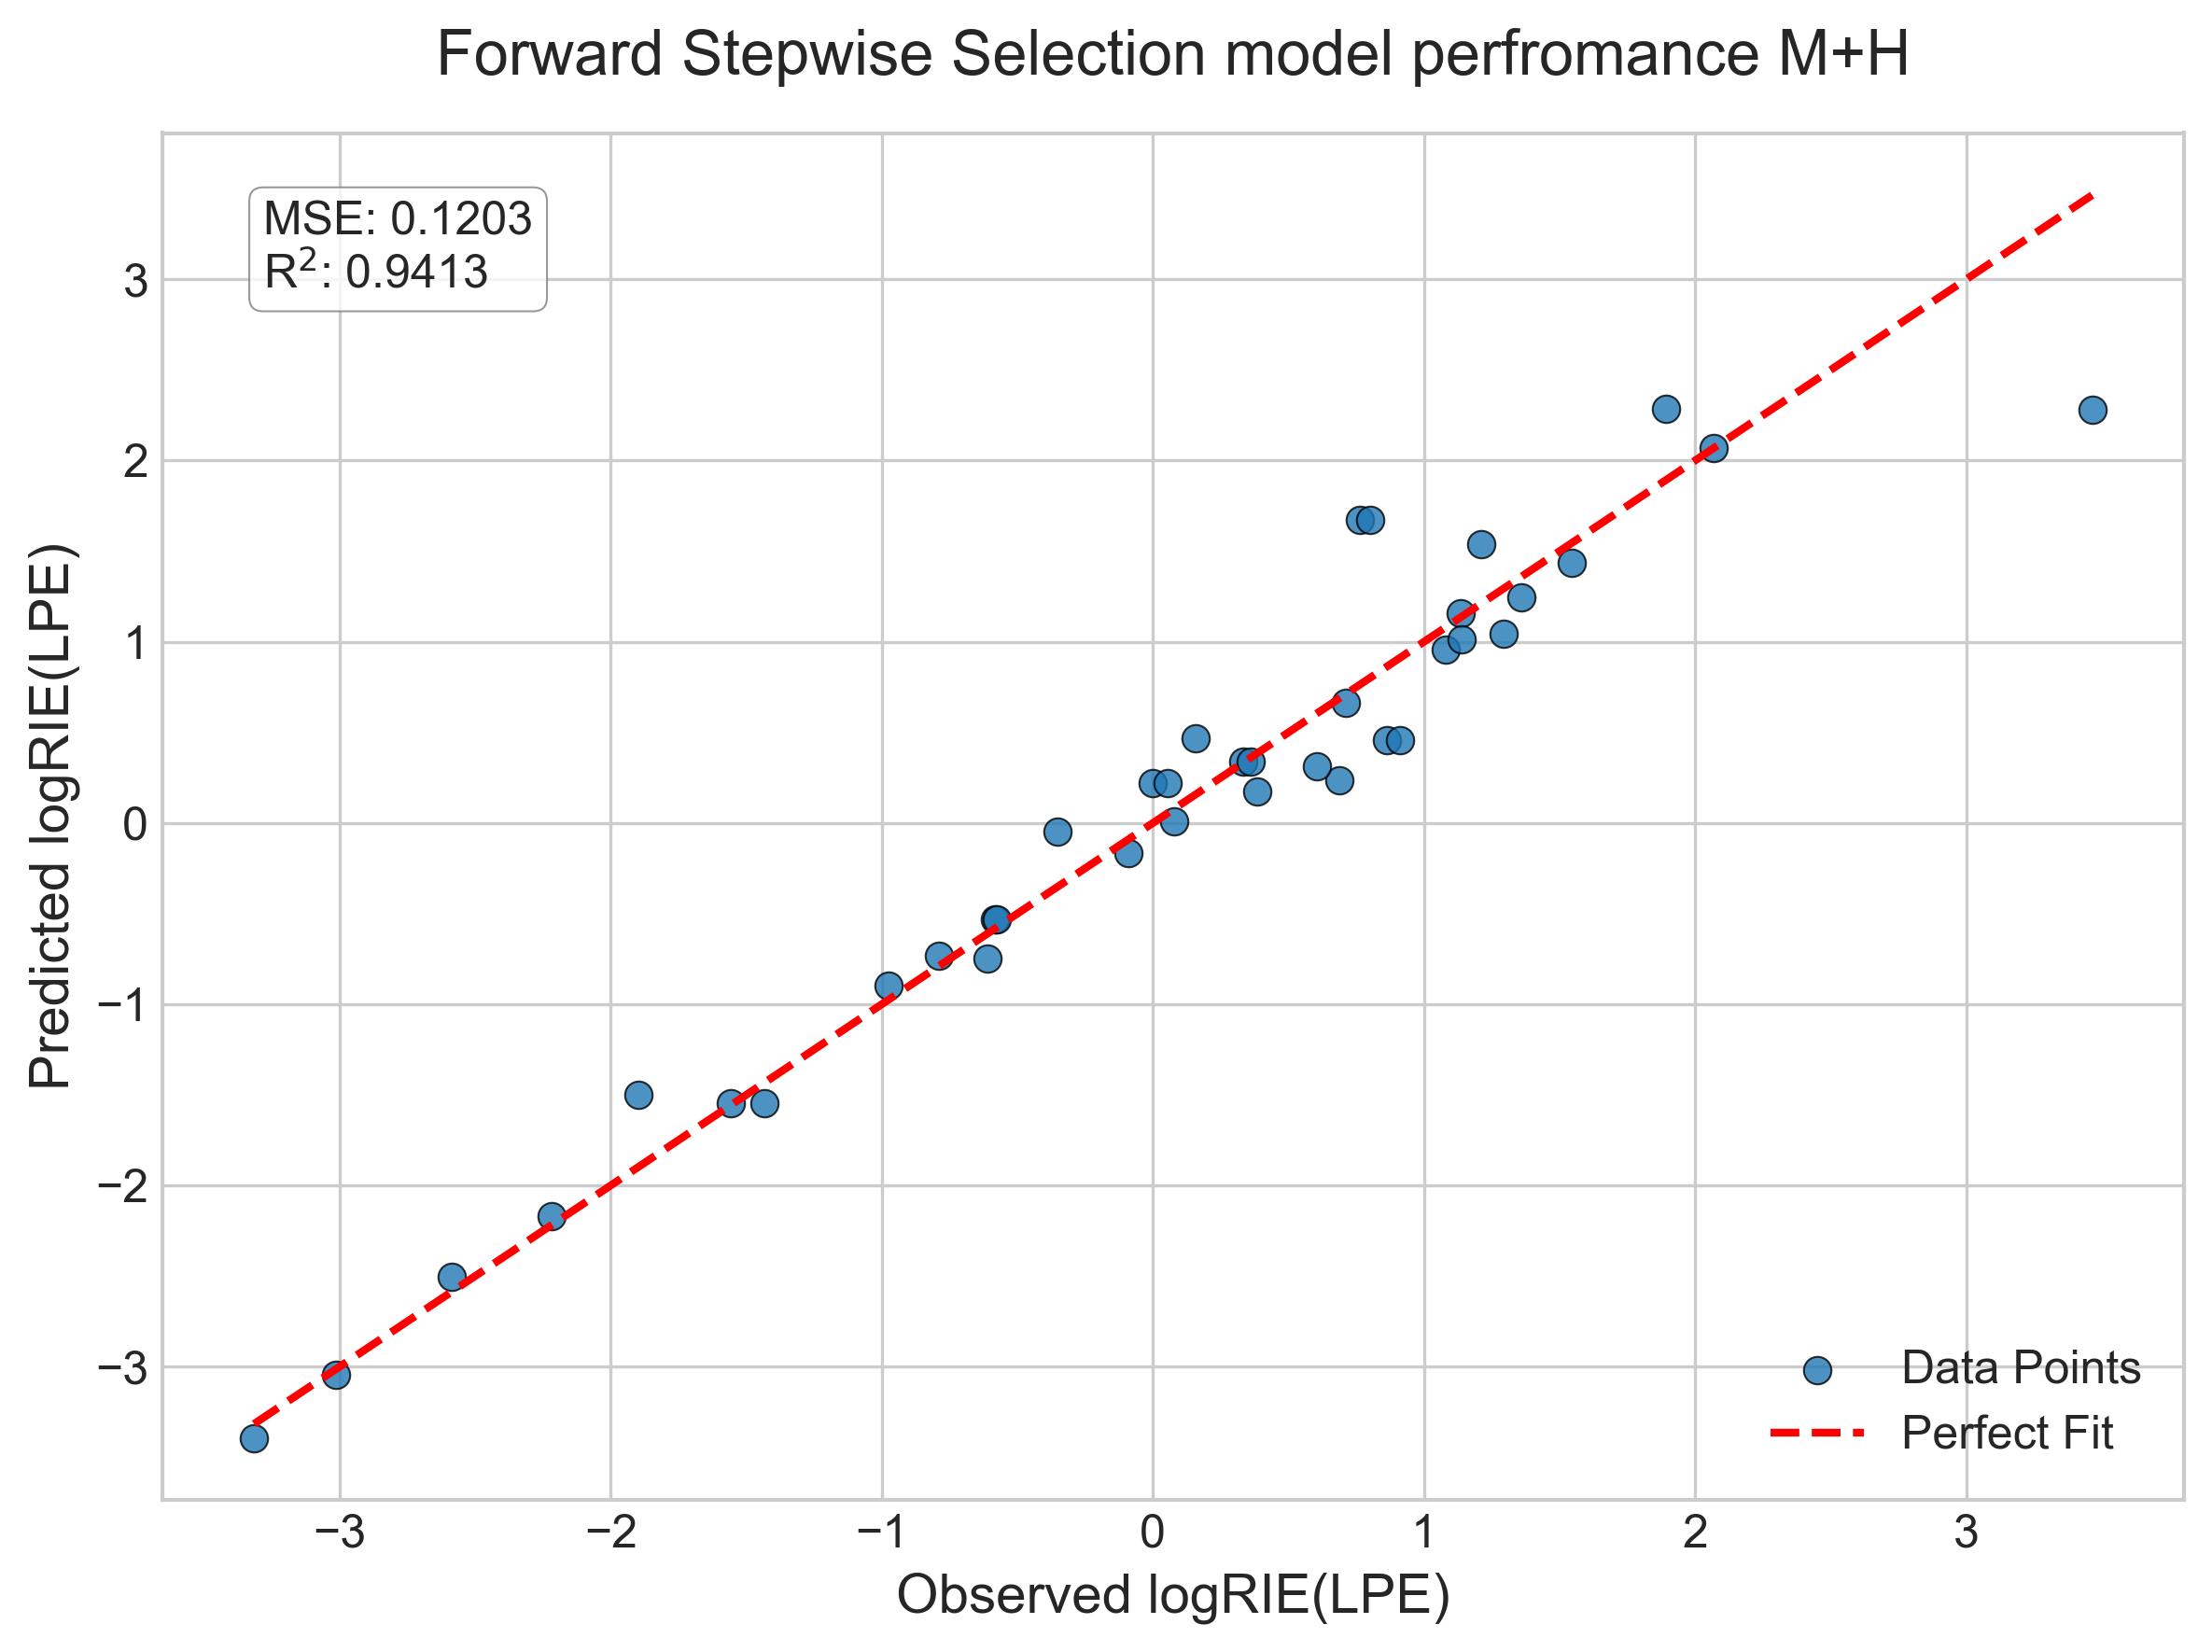

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# Use an available Seaborn style
plt.style.use('seaborn-v0_8-whitegrid')

# Create a high-resolution figure
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Scatter plot of observed vs predicted values
ax.scatter(y, y_pred, color='#1f77b4', s=50, alpha=0.8, edgecolor='k', label='Data Points')

# Perfect fit line (dashed red line)
x_vals = np.linspace(y.min(), y.max(), 100)
ax.plot(x_vals, x_vals, linestyle='--', color='red', lw=2, label='Perfect Fit')

# Calculate metrics
mse_full_data = ((y - y_pred) ** 2).mean()
r2_full_data = final_model.rsquared

# Create a statistics text box in the top left corner
stats_text = f'MSE: {mse_full_data:.4f}\nR$^2$: {r2_full_data:.4f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# Set axis labels and title with increased font sizes for publication
ax.set_xlabel('Observed logRIE(LPE)', fontsize=14)
ax.set_ylabel('Predicted logRIE(LPE)', fontsize=14)
ax.set_title('Forward Stepwise Selection model perfromance (M+H)', fontsize=16, pad=15)

# Improve tick parameters for better readability
ax.tick_params(axis='both', which='major', labelsize=12)

# Place the legend in a location that does not obscure the data
ax.legend(loc='lower right', fontsize=12)

# Adjust layout for a clean look
plt.tight_layout()

plt.show()

In [12]:
import pandas as pd
data_to_export = pd.DataFrame({'Observed': y, 'Predicted': y_pred})
data_to_export.to_csv('plot_data-M+H.csv', index=False)

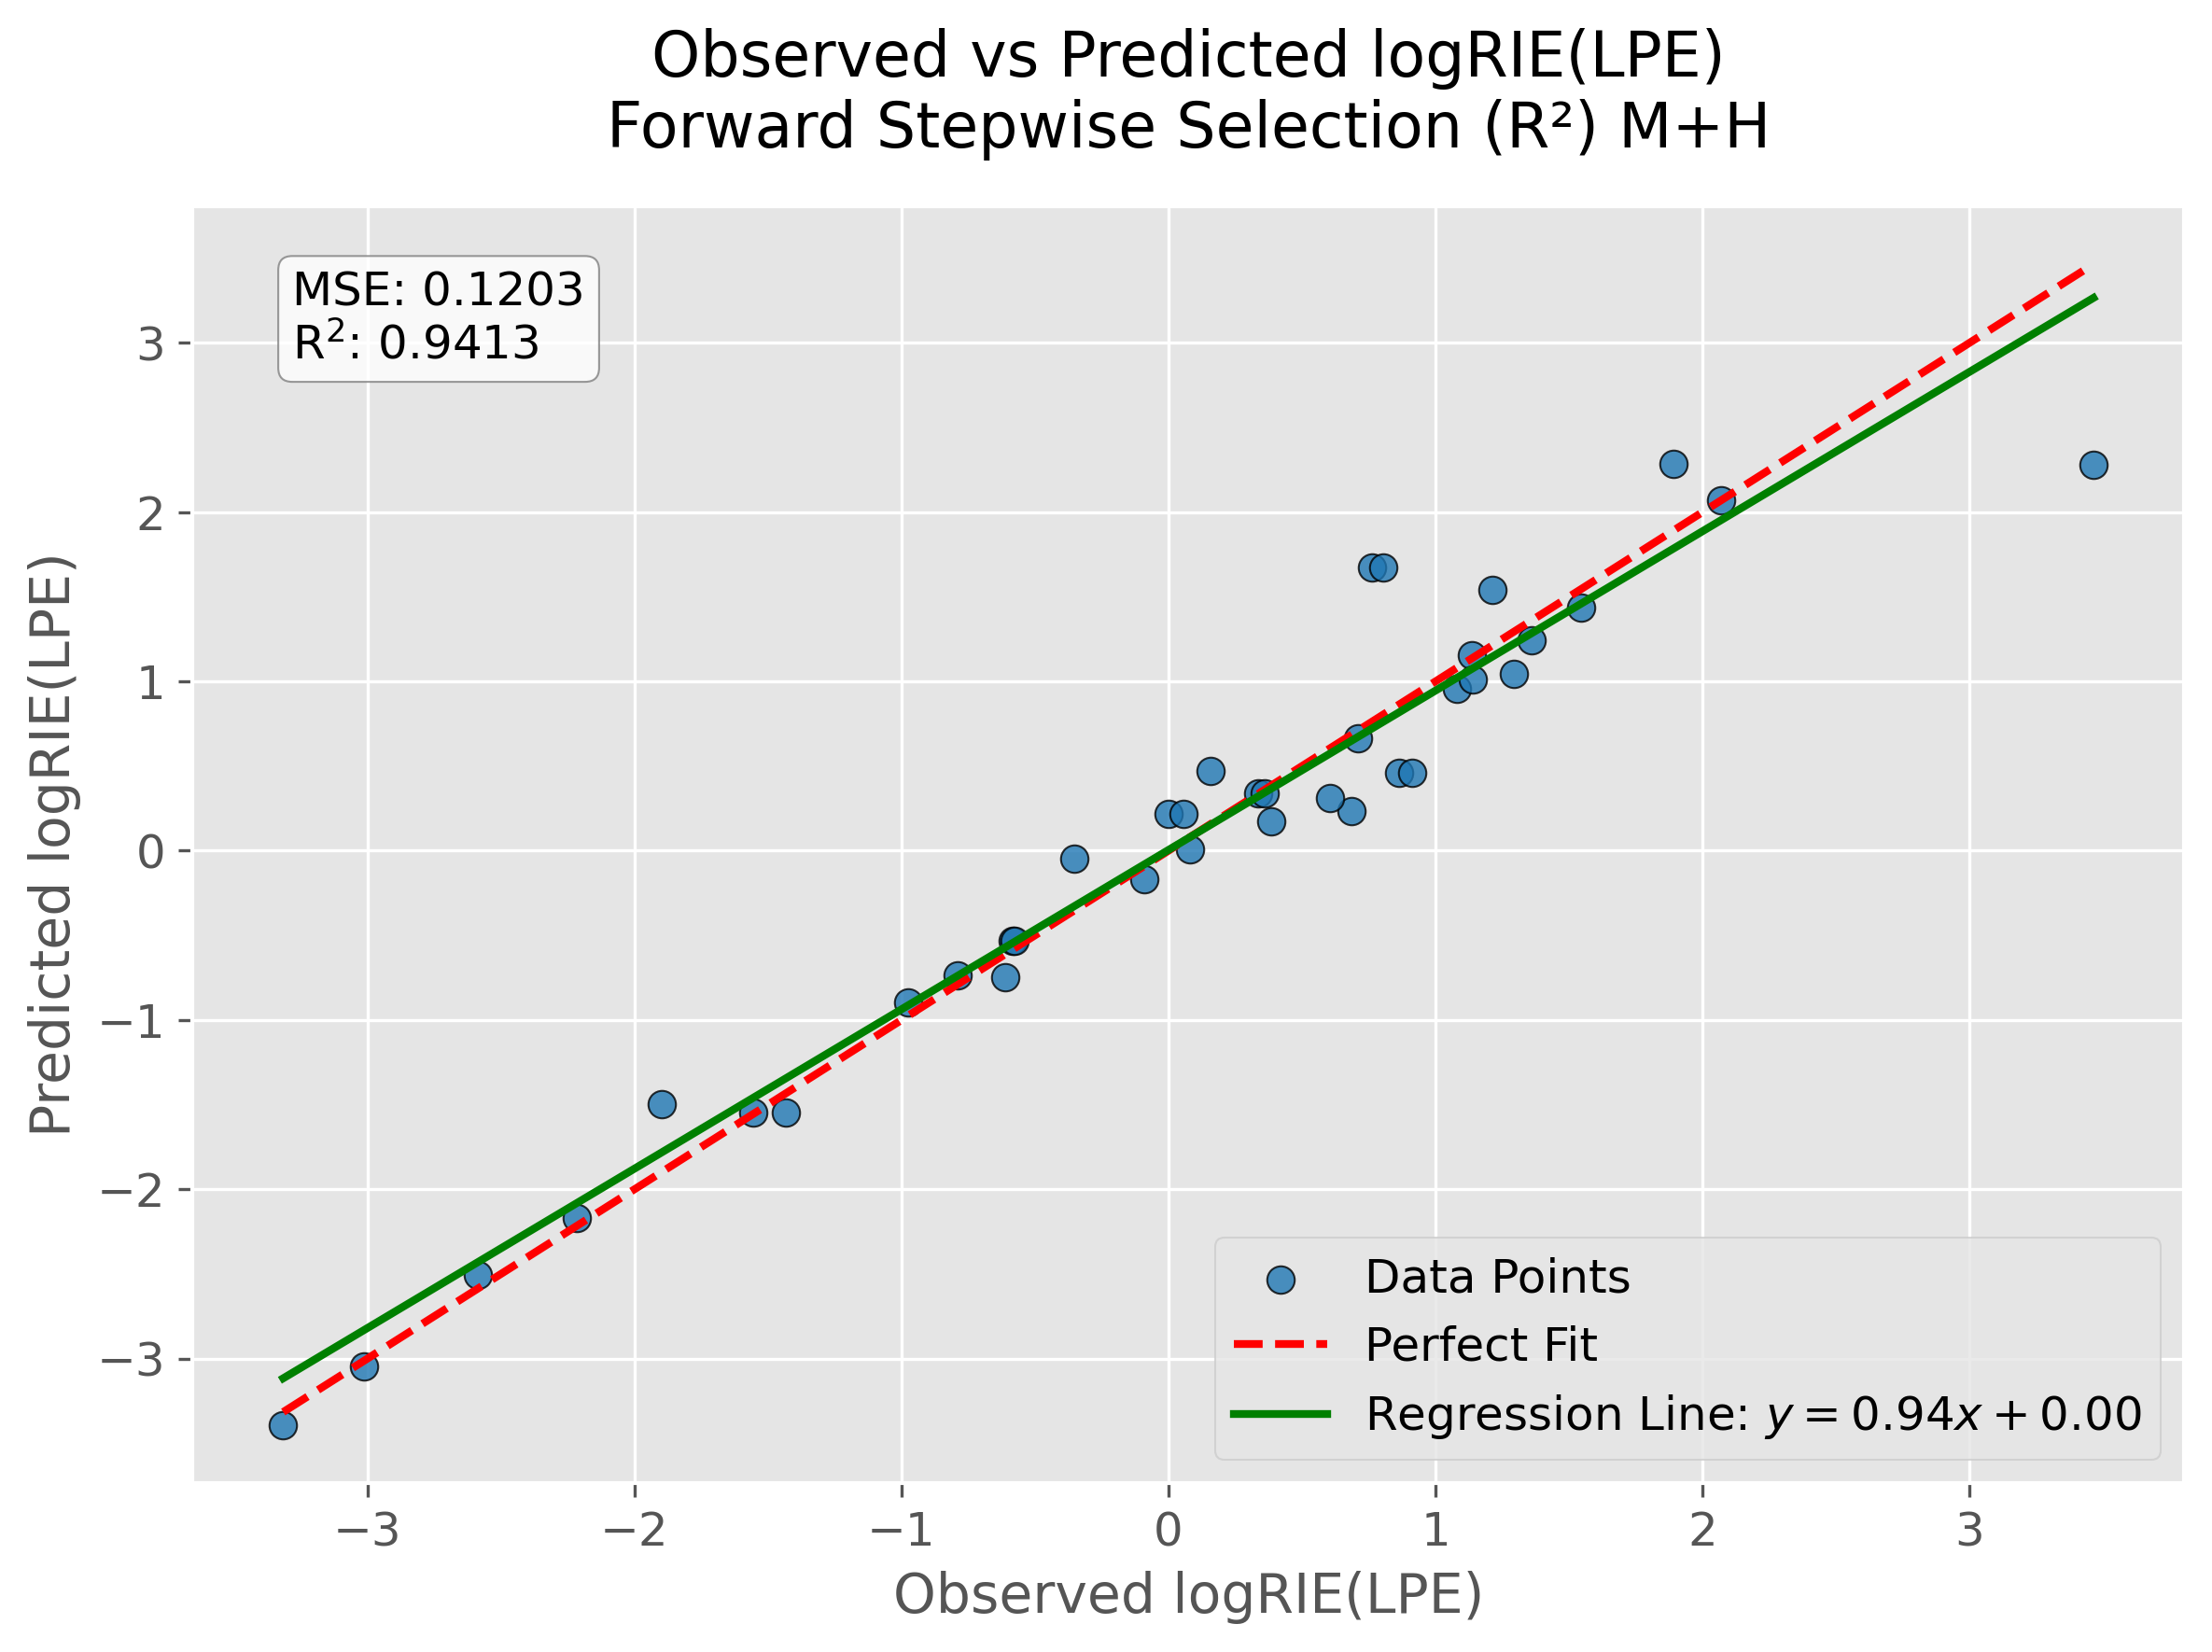

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# Use an available style; you can change 'ggplot' to any style from plt.style.available
plt.style.use('ggplot')

# Create a high-resolution figure
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Scatter plot of observed vs predicted values
ax.scatter(y, y_pred, color='#1f77b4', s=50, alpha=0.8, edgecolor='k', label='Data Points')

# Perfect fit line (dashed red line)
x_vals = np.linspace(y.min(), y.max(), 100)
ax.plot(x_vals, x_vals, linestyle='--', color='red', lw=2, label='Perfect Fit')

# Linear regression line (solid green line)
slope, intercept, r_value, p_value, std_err = linregress(y, y_pred)
reg_line = slope * x_vals + intercept
ax.plot(x_vals, reg_line, color='green', lw=2, label=f'Regression Line: $y={slope:.2f}x+{intercept:.2f}$')

# Calculate metrics
mse_full_data = ((y - y_pred) ** 2).mean()
r2_full_data = final_model.rsquared

# Create a statistics text box in the top left corner
stats_text = f'MSE: {mse_full_data:.4f}\nR$^2$: {r2_full_data:.4f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# Set axis labels and title with increased font sizes for publication
ax.set_xlabel('Observed logRIE(LPE)', fontsize=14)
ax.set_ylabel('Predicted logRIE(LPE)', fontsize=14)
ax.set_title('Observed vs Predicted logRIE(LPE)\nForward Stepwise Selection (R²) M+H', fontsize=16, pad=15)

# Improve tick parameters for better readability
ax.tick_params(axis='both', which='major', labelsize=12)

# Place the legend in a location that does not obscure the data
ax.legend(loc='lower right', fontsize=12)

# Adjust layout for a clean look
plt.tight_layout()

plt.show()

In [6]:
!pip3 install seaborn

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try brew install
    xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a Python library that isn't in Homebrew,
    use a virtual environment:
    
    python3 -m venv path/to/venv
    source path/to/venv/bin/activate
    python3 -m pip install xyz
    
    If you wish to install a Python application that isn't in Homebrew,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. You can install pipx with
    
    brew install pipx
    
    You may restore the old behavior of pip by passing
    the '--break-system-packages' flag to pip, or by adding
    'break-system-packages = true' to your pip.conf file. The latter
    will permanently disable this error.
    
    If you disable this error, we STRONGLY recommend that you additionally
    pass the '--user' flag to pip, or set 

In [13]:
def generate_regression_equation(feature_weights):
    intercept = feature_weights.loc[feature_weights['Feature'] == 'Intercept', 'Weight'].values[0]
    terms = [f"{row['Weight']:.4f} * {row['Feature']}" for _, row in feature_weights.iterrows() if row['Feature'] != 'Intercept']
    return f"logRIE(LPE) = {intercept:.4f} + " + " + ".join(terms)

# Generate and display the equation
equation = generate_regression_equation(feature_weights)
print("Regression Model Equation:")
print(equation)


Regression Model Equation:
logRIE(LPE) = 7.2289 + -19.4016 * GATS1s + 12.5916 * GATS3m + 1.0432 * nN + 0.1584 * VR2_D + -12.8884 * R_TpiPCTPC + 113.4394 * MATS4s + 8.7056 * MATS1s + -8.9186 * MATS3c + 22.4928 * GATS2s + -0.3476 * VR2_Dt
